In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

from tqdm import tqdm_notebook
from collections import deque

In [2]:
#[ 0,  1,  2,  3,  4,  5,  6,  7,  8, 9, 10, 11]
#[Cs, Cd, Gs, Gd, Ts, Td, Ns, Nd, Yd, Y, Hs, Hh]

In [3]:
def system_transition(state):
    #print(state)
    
    Gd = state[3]
    Gs = Gd
    
    Y = ((80 / 3) + (4 / 6) * state[11]) / 5 + 4 * state[9] / 5
    Yd = Y / 2
    
    Nd = Y
    Ns = Y
    
    Ts = (1 / 2) * Y
    Td = (1 / 2) * Y
    
    Cd = (1 / 4) * Y + (1 / 2) * state[11]
    Cs = Cd
    
    Hs = 20 - (1 / 2) * Y + state[10]
    Hh = (1 / 2) * Y - Cd
    
    return [Cs, Cd, Gs, Gd, Ts, Td, Ns, Nd, Yd, Y, Hs, Hh]

In [4]:
class Environment():
    
    def __init__(self):
        
        self.trans_func = system_transition
                    #[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  10,  11]
                    #[Cs, Cd, Gs, Gd, Ts, Td, Ns, Nd, Yd,  Y,  Hs,  Hh]
        self.state = [ 0,  0,  0, 20,  0,  0,  0,  0,  0, 30, 100, 100]
        self.statehistory = []
        
        for i in range(50):
            self.state = self.trans_func(self.state)
            self.statehistory.append(self.state)
            
        self.actions = [1, 0.99, 0.97, 0.95, 0.9, 1.01, 1.03, 1.05, 1.1]
        self.y_steady_state = np.mean([i[9] for i in self.statehistory[-10:]])
        self.running_loss = 0
        self.episode_num = 0
         
    def printstate(self):
        print(self.state)
        
    def reset(self):
        
        self.trans_func = system_transition
                    #[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  10,  11]
                    #[Cs, Cd, Gs, Gd, Ts, Td, Ns, Nd, Yd,  Y,  Hs,  Hh]
        self.state = [ 0,  0,  0, 20,  0,  0,  0,  0,  0, 30, 100, 100]
        self.statehistory = []
        for i in range(50):
            self.state = self.trans_func(self.state)
            self.statehistory.append(self.state)
            
        self.actions = [1, 0.99, 0.97, 0.95, 0.9, 1.01, 1.03, 1.05, 1.1]
        self.y_steady_state = np.mean([i[9] for i in self.statehistory[-10:]])
        self.running_loss = 0
        self.episode_num = 0
            
    def observation(self):
        
        return torch.tensor([item for sublist in self.statehistory[-11:-2] for item in sublist])
    
    
    def step(self, action):
        
        self.state = self.trans_func(self.state)
        if self.episode_num % 40 == 0:
            #print("H")
            self.state[9] = self.state[9]*1.5
            #print("H")
         
        if action is not None:
            self.state[4] = np.clip(self.actions[action] * self.state[4], 15, 25)
        self.statehistory.append(self.state)
        self.running_loss += (self.state[9] - self.y_steady_state)**2 / self.y_steady_state
        self.episode_num += 1
        
        return self.state, 100 - abs(self.state[9] - self.y_steady_state)/self.y_steady_state , self.episode_num == 100   

In [5]:
env = Environment()
for i in range(100):
    env.step(None)

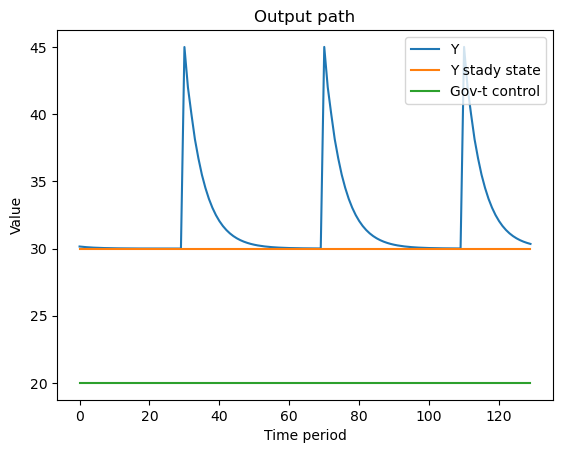

In [6]:
plt.title(label="Output path")
plt.plot([i[9] for i in env.statehistory][20:], label = "Y");
plt.plot([30 for i in env.statehistory][20:], label = "Y stady state");
plt.plot([20 for i in env.statehistory][20:],label = "Gov-t control")
plt.xlabel('Time period');
plt.ylabel('Value');
plt.legend();

In [11]:
# Observation -----> Action
class Actor(nn.Module):
    
    def __init__(self, observation_space, action_space):
        super(Actor, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, action_space)
    
    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        actions = self.output_layer(x)
        action_probs = F.softmax(actions, dim=1)
        
        return action_probs
    
# State -----> Reward
class Critic(nn.Module):

    def __init__(self, observation_space):
        super(Critic, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, 1)
        
    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        state_value = self.output_layer(x)

        return state_value
    
# Network + State -----> Action    
def select_action(network, state):

    state = np.array(state)
    state = torch.from_numpy(state).float().unsqueeze(0)

    action_probs = network(state)
    state = state.detach()
    
    m = Categorical(action_probs)
    action = m.sample()

    return action.item(), m.log_prob(action)

In [13]:
DEVICE =  "cpu"
stateval_network = Critic(len(env.state)).to(DEVICE)
policy_network = Actor(len(env.state), len(env.actions)).to(DEVICE)

In [14]:
policy_optimizer = optim.SGD(policy_network.parameters(), lr=0.001)
stateval_optimizer = optim.SGD(stateval_network.parameters(), lr=0.001)

In [16]:
DISCOUNT_FACTOR = 0.999
NUM_EPISODES = 1000
MAX_STEPS = 10000
DEVICE =  "cpu"

scores = []
recent_scores = deque(maxlen = 100)

for episode in tqdm_notebook(range(NUM_EPISODES)):
    
    env.reset()
    state = env.state
    done = False
    score = 0
    I = 1
    
    for step in range(MAX_STEPS):
        

        action, lp = select_action(policy_network, state)

        new_state, reward, done = env.step(action)

        score += reward

        state_tensor = torch.tensor(state).float().to(DEVICE)
        state_val = stateval_network(state_tensor)
        

        new_state_tensor = torch.tensor(new_state).float().to(DEVICE) 
        new_state_val = stateval_network(new_state_tensor)
        

        if done:
            new_state_val = torch.tensor([0]).to(DEVICE)
        

        val_loss = F.mse_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val)
        val_loss *= I
        advantage = reward + DISCOUNT_FACTOR * new_state_val.item() - state_val.item()
        policy_loss = -lp * advantage
        policy_loss *= I
        policy_optimizer.zero_grad()
        policy_loss.backward(retain_graph=True)
        policy_optimizer.step()
        

        stateval_optimizer.zero_grad()
        val_loss.backward()
        stateval_optimizer.step()
        
        if done:
            break

        state = new_state
        I *= DISCOUNT_FACTOR

    scores.append(score)
    recent_scores.append(score)

/var/folders/w6/qhzfl2zs7fz7szd_t214c1kr0000gn/T/ipykernel_84703/3492493245.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for episode in tqdm_notebook(range(NUM_EPISODES)):


  0%|          | 0/1000 [00:00<?, ?it/s]

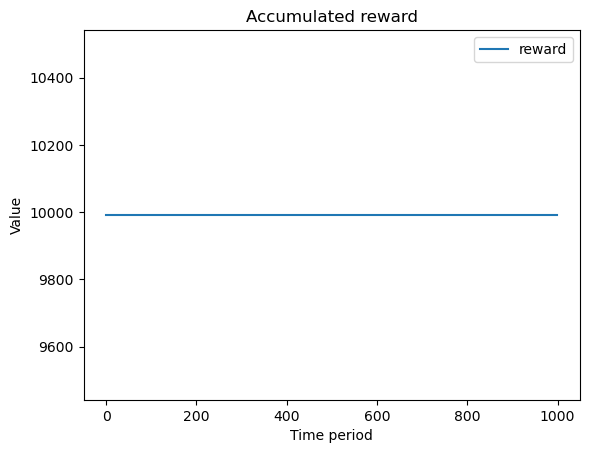

In [27]:
plt.plot(scores, label = 'reward');
plt.title(label="Accumulated reward")

plt.xlabel('Time period');
plt.ylabel('Value');
plt.legend();


In [25]:
#plt.plot([i[3] for i in env.statehistory], label = "Y stady state");